# Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from matplotlib import pyplot as plt
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics
from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
import pprint
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis
from gemseo import from_pickle
from lh2pac.utils import update_default_inputs
from gemseo_oad_training.unit import convert_from


configure_logger()

<RootLogger root (INFO)>

# Instanciate disciplines

In [2]:
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

# Fix optimal parameters

In [3]:
update_default_inputs(disciplines, {"slst": 128421.91149125, "n_pax":128.14643539, "area":126.51395189, "ar":10.73253045, "fuel_type":"liquid_h2"})
disciplines[0].io.input_grammar.defaults

{'area': 126.51395189, 'ar': 10.73253045, 'length': 37.0, 'aef': 1.0}

# Create uncertain space

In [4]:
uncertain_space = ParameterSpace()

uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("gi", "OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi", "OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)

# Import surrogate model

In [5]:
surrogate_disciplines = from_pickle("UC2_my_surrogate_2.pkl")
surrogate_disciplines

Surrogate discipline: RBF_Sampling
   Dataset name: Sampling
   Dataset size: 20
   Surrogate model: RBFRegressor
   Inputs: aef, cef, gi, sef, vi
   Outputs: fm, length, mtom, span, tofl, vapp, vz
   Linearization mode: auto

# Create sample dataset


In [6]:
surrogate_dataset = sample_disciplines([surrogate_disciplines], uncertain_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_MONTE_CARLO", n_samples=5000)

 WARNING - 11:55:19: No coupling in MDA, switching chain_linearize to True.
    INFO - 11:55:19: *** Start Sampling execution ***
    INFO - 11:55:19: Sampling
    INFO - 11:55:19:    Disciplines: RBF_Sampling
    INFO - 11:55:19:    MDO formulation: MDF
    INFO - 11:55:19: Running the algorithm OT_MONTE_CARLO:
    INFO - 11:55:33:    100%|██████████| 5000/5000 [00:13<00:00, 376.71 it/sec]
    INFO - 11:55:33: *** End Sampling execution (time: 0:00:13.345964) ***


# Check stat

In [7]:
statistics = EmpiricalStatistics(surrogate_dataset)
mean = statistics.compute_mean()
print(mean)

std = statistics.compute_standard_deviation()
print(std)

{'aef': array([1.00677577]), 'cef': array([1.00675571]), 'fm': array([0.11456296]), 'gi': array([0.38476638]), 'length': array([36.10773923]), 'mtom': array([68051.37370006]), 'sef': array([1.0066107]), 'span': array([36.8485392]), 'tofl': array([1505.04863738]), 'vapp': array([68.11366519]), 'vi': array([0.78662059]), 'vz': array([6.22539539])}
{'aef': array([0.00852103]), 'cef': array([0.00864282]), 'fm': array([0.01811603]), 'gi': array([0.01243155]), 'length': array([7.10542736e-15]), 'mtom': array([546.82668644]), 'sef': array([0.00841865]), 'span': array([0.]), 'tofl': array([22.65522262]), 'vapp': array([0.28256205]), 'vi': array([0.01121262]), 'vz': array([0.16232082])}


# Propagate uncertainties

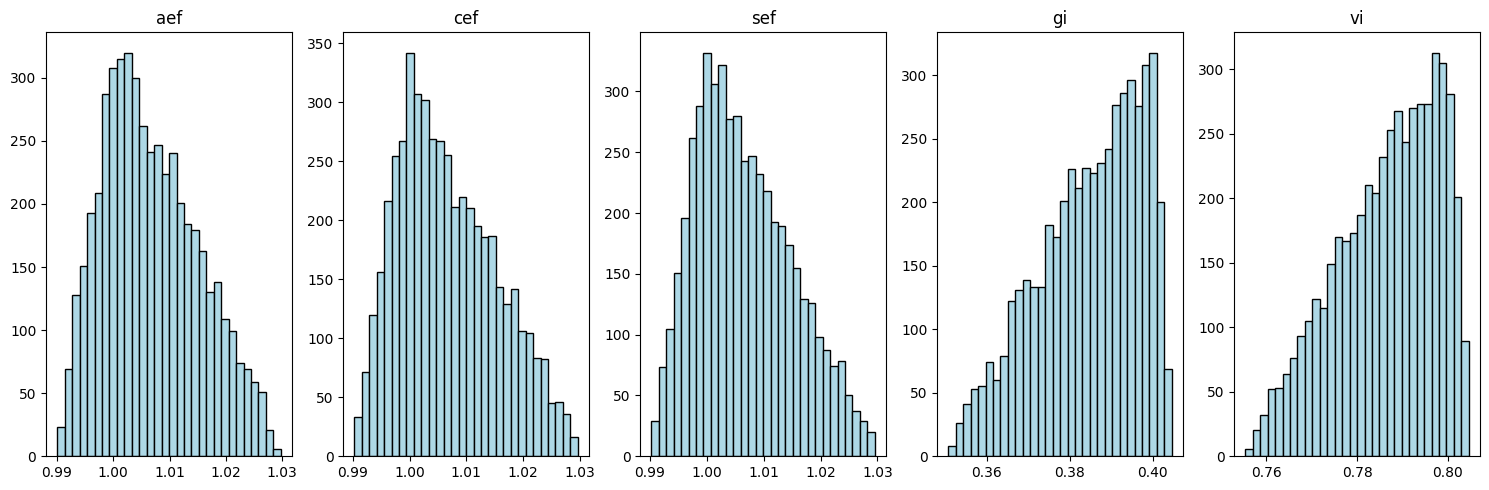

In [8]:
variable_names = ["aef", "cef", "sef", "gi", "vi"]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes = axes.ravel()

for ax, name in zip(axes, variable_names ):
    data = surrogate_dataset.get_view(variable_names=name)
    ax.hist(data, bins=30, color='lightblue', edgecolor='black')


    ax.set_title(name)

if len(variable_names) < len(axes):
    for ax in axes[len(variable_names):]:
        ax.axis('off')

plt.tight_layout()
plt.show()


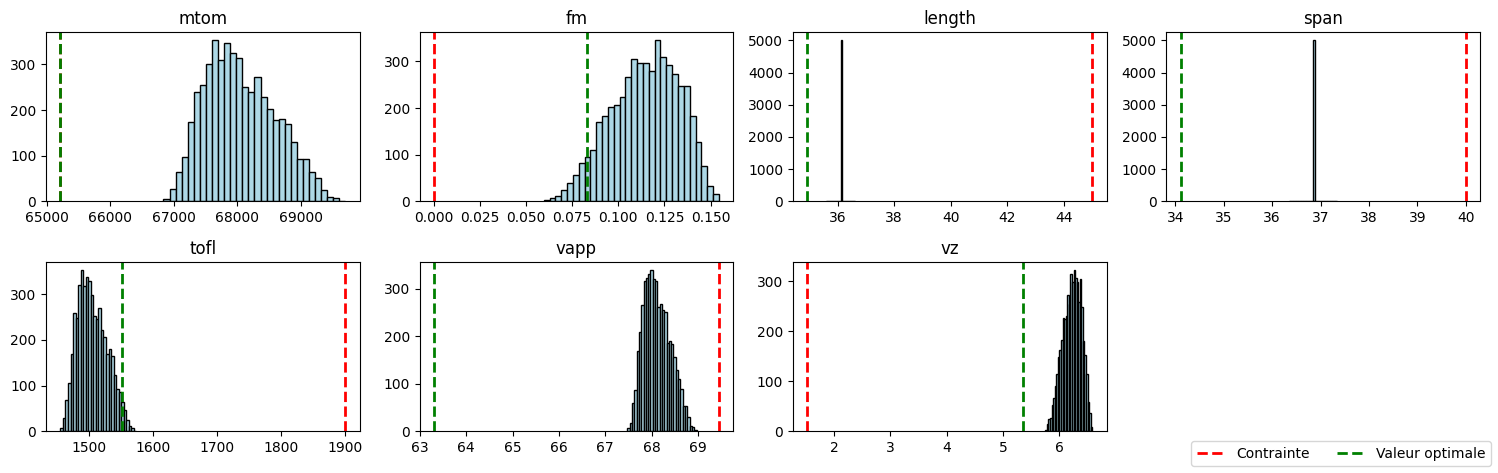

In [9]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

variable_names = ["mtom", "fm", "length", "span", "tofl", "vapp", "vz"]

constraints = [65214.94, 0, 45, 40, 1900, convert_from("kt",135.0), convert_from("ft/min",300.0)] 
optimum_values = [
    65214.94, 
    0.083, 
    34.93, 
    34.11, 
    1550.81, 
    63.30, 
    5.36
] 

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.ravel()

for ax, name, cons_val, opt_val in zip(axes, variable_names, constraints, optimum_values):
# for ax, name, opt_val in zip(axes, variable_names, optimum_values):

    data = surrogate_dataset.get_view(variable_names=name)
    ax.hist(data, bins=30, color='lightblue', edgecolor='black')
    ax.axvline(cons_val, color='red', linestyle='--', linewidth=2)
    ax.axvline(opt_val, color='green', linestyle='--', linewidth=2)
    ax.set_title(name)

if len(variable_names) < len(axes):
    for ax in axes[len(variable_names):]:
        ax.axis('off')

red_line = Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Contrainte')
green_line = Line2D([0], [0], color='green', linestyle='--', linewidth=2, label='Valeur optimale')
# fig.legend(handles=[green_line], loc='lower right', ncol=2)
fig.legend(handles=[red_line, green_line], loc='lower right', ncol=2)


plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


# Sobol analysis

In [10]:
sobol = SobolAnalysis()
samples = sobol.compute_samples([surrogate_disciplines], uncertain_space, 10000)
sobol.compute_indices(output_names=["mtom", "fm", 'tofl', "vapp" ])

 WARNING - 12:03:03: No coupling in MDA, switching chain_linearize to True.
    INFO - 12:03:03: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 12:03:03: SobolAnalysisSamplingPhase
    INFO - 12:03:03:    Disciplines: RBF_Sampling
    INFO - 12:03:03:    MDO formulation: MDF
    INFO - 12:03:03: Running the algorithm OT_SOBOL_INDICES:
    INFO - 12:03:31:    100%|██████████| 9996/9996 [00:27<00:00, 367.10 it/sec]
    INFO - 12:03:31: *** End SobolAnalysisSamplingPhase execution (time: 0:00:27.390760) ***


SobolAnalysis.SensitivityIndices(first={'mtom': [{'aef': array([0.04207669]), 'cef': array([0.04714654]), 'sef': array([0.28363276]), 'gi': array([0.76528255]), 'vi': array([0.0936254])}], 'fm': [{'aef': array([0.09707368]), 'cef': array([0.27876288]), 'sef': array([0.03369401]), 'gi': array([0.03313823]), 'vi': array([0.71297266])}], 'tofl': [{'aef': array([0.0421105]), 'cef': array([0.04718651]), 'sef': array([0.28343796]), 'gi': array([0.76668625]), 'vi': array([0.0934058])}], 'vapp': [{'aef': array([0.04116343]), 'cef': array([0.04410891]), 'sef': array([0.28789189]), 'gi': array([0.76407844]), 'vi': array([0.09620833])}]}, second={'mtom': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.07928044]]), 'sef': array([[-0.07949168]]), 'gi': array([[-0.08529178]]), 'vi': array([[-0.08047608]])}, 'cef': {'aef': array([[-0.07928044]]), 'cef': array([[0.]]), 'sef': array([[-0.08774094]]), 'gi': array([[-0.08647336]]), 'vi': array([[-0.09050591]])}, 'sef': {'aef': array([[-0.07949168]]), '

In [11]:
# pprint.pprint(sobol.indices.first)
# pprint.pprint(sobol.indices.total)

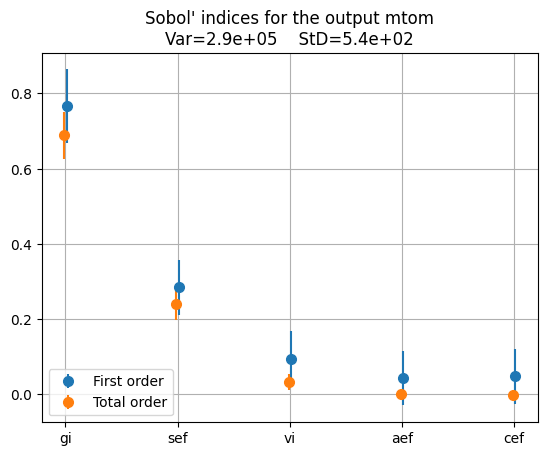

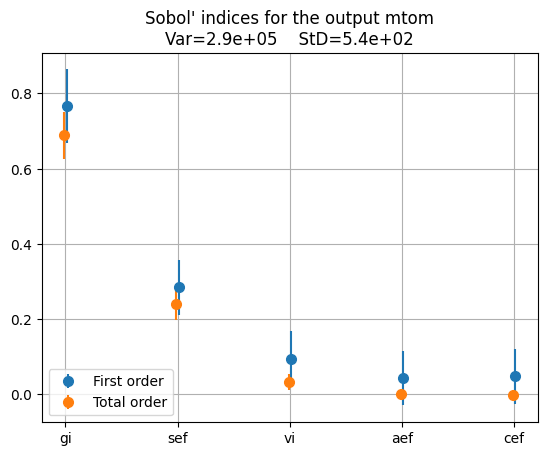

In [16]:
sobol.plot("mtom", save=False, show=False)

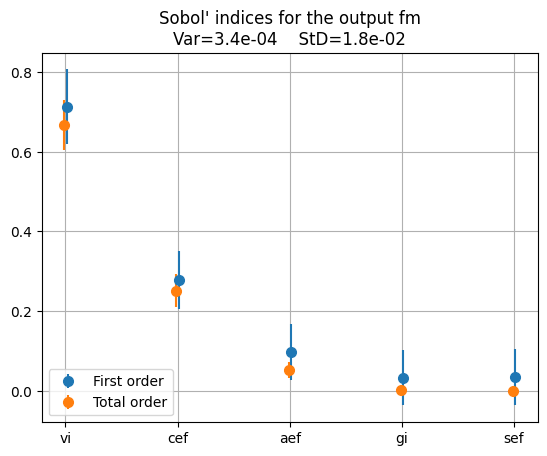

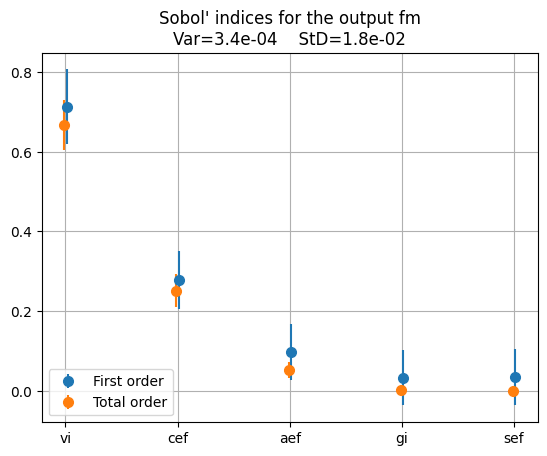

In [17]:
sobol.plot("fm", save=False, show=False)

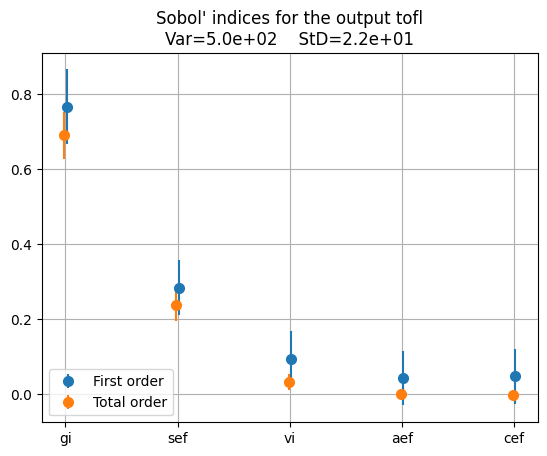

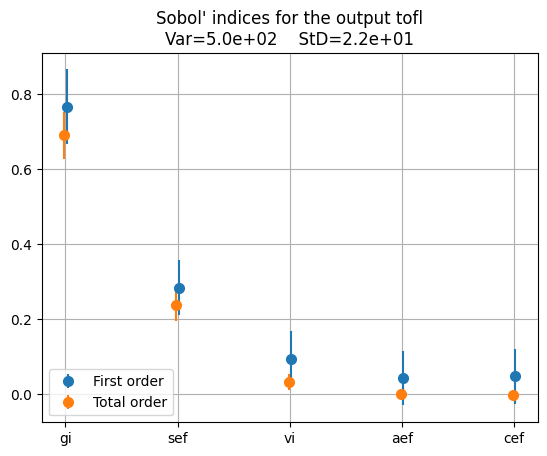

In [18]:
sobol.plot("tofl", save=False, show=False)

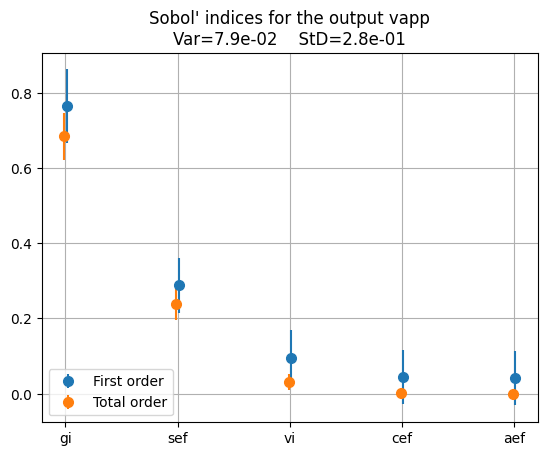

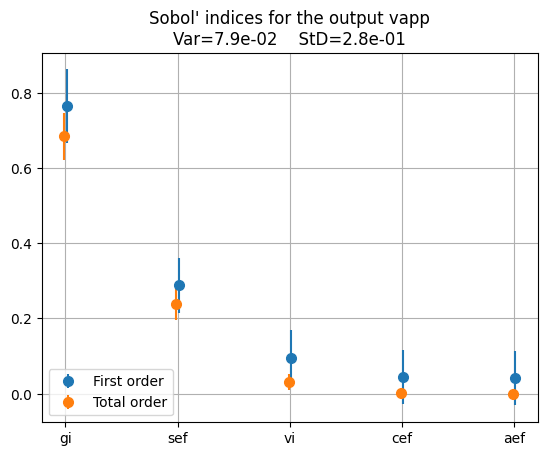

In [19]:
sobol.plot("vapp", save=False, show=False)